In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import sys
import os

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import TimeDistributed,Bidirectional,GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM,GRU,SimpleRNN,BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as sp
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

2024-04-30 16:45:43.296172: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 16:45:43.497920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:45:46.000552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 16:45:46.008857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

import numpy as np
import os
from tensorflow import keras
#import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [3]:
data_path = "/home/muhlabws4/Masaüstü/tkd_data/orj"

In [4]:
class_folders = os.listdir(data_path)

In [21]:
images = []
labels = []

In [22]:
for i , class_name in enumerate(class_folders):
    class_folder_path = os.path.join(data_path, class_name)
    class_images = os.listdir(class_folder_path)
    
    for img_name in class_images:
        img_path = os.path.join(class_folder_path, img_name)
        img = load_img(img_path, target_size=(128,128))
        img_array = img_to_array(img) /255.0
        images.append(img_array)
        labels.append(class_name)

In [23]:
X = np.array(images)
y = np.array(labels)

In [24]:
label_encoder = LabelEncoder()
y_encoder = label_encoder.fit_transform(y)

In [25]:
X_shuf, y_shuf = X, y_encoder

In [26]:
train_images, test_images, train_labels, test_labels = train_test_split(X_shuf, y_shuf, test_size=0.2, random_state=42)

In [27]:
print(X.shape)
print(y.shape)
print(y_encoder.shape)

(407, 128, 128, 3)
(407,)
(407,)


In [28]:
#class_names = ['head_sb','head_sesor', 'other','punch','rotation']
class_names = ['head', 'other','punch']

In [29]:
img_height=128
img_width=128
output=3

In [30]:
checkpoint_path = "best_modelresnet.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [39]:
def pretrained_resnet():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape = (img_height,img_width,3))
    base_model.trainable = True ## Not trainable weights
    flatten_layer = Flatten()
    dense_layer_1 = Dense(256, activation='relu')
    #dense_layer_2 = Dense(20, activation='relu')
    prediction_layer = Dense(output, activation='softmax')
    
    model = Sequential([
      base_model,
      flatten_layer,
      dense_layer_1,
      #dense_layer_2,
      prediction_layer
      ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    return model

In [40]:
def cross_validation(model, X, y, n_splits=5, epochs=5, batch_size=32):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    #model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #result = []
    for train_inx, val_inx in kfold.split(X):
        X_train, X_val = X[train_inx], X[val_inx]
        y_train, y_val = y[train_inx], y[val_inx]
        
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        a = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, class_weight={0:7,1:10,2:22},callbacks=[checkpoint])
        #model.fit(X_train, y_train, epochs=epochs)
        #result.append(a.history['val_accuracy'])
        
    #return result

In [33]:
def gosterTrain(index):
    plt.figure(figsize=(15,2))
    plt.imshow(train_images[index])
    plt.title(class_names[train_labels[index]])

In [34]:
def gosterTest(index):
    plt.figure(figsize=(15,2))
    plt.imshow(test_images[index])
    plt.title(class_names[test_labels[index]])

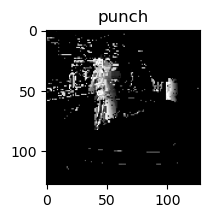

In [35]:
gosterTrain(10)

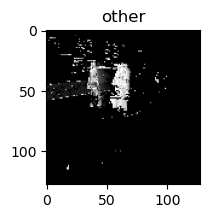

In [36]:
gosterTest(7)

In [41]:
model = pretrained_resnet()
result = cross_validation(model, train_images, train_labels, n_splits=2, epochs=10, batch_size=32)

Epoch 1/10
6/6 - 10s - loss: 175.6223 - accuracy: 0.4259 - 10s/epoch - 2s/step
Epoch 2/10
6/6 - 2s - loss: 12.6183 - accuracy: 0.6790 - 2s/epoch - 359ms/step
Epoch 3/10
6/6 - 2s - loss: 14.3394 - accuracy: 0.4938 - 2s/epoch - 358ms/step
Epoch 4/10
6/6 - 2s - loss: 14.2170 - accuracy: 0.6605 - 2s/epoch - 358ms/step
Epoch 5/10
6/6 - 2s - loss: 10.2181 - accuracy: 0.6667 - 2s/epoch - 358ms/step
Epoch 6/10
6/6 - 2s - loss: 13.7917 - accuracy: 0.6173 - 2s/epoch - 356ms/step
Epoch 7/10
6/6 - 2s - loss: 12.5530 - accuracy: 0.6111 - 2s/epoch - 357ms/step
Epoch 8/10
6/6 - 2s - loss: 11.8418 - accuracy: 0.6358 - 2s/epoch - 359ms/step
Epoch 9/10
6/6 - 2s - loss: 8.4736 - accuracy: 0.6543 - 2s/epoch - 356ms/step
Epoch 10/10
6/6 - 2s - loss: 6.7775 - accuracy: 0.6667 - 2s/epoch - 356ms/step
Epoch 1/10
6/6 - 10s - loss: 26.4619 - accuracy: 0.5276 - 10s/epoch - 2s/step
Epoch 2/10
6/6 - 2s - loss: 30.3755 - accuracy: 0.5706 - 2s/epoch - 364ms/step
Epoch 3/10
6/6 - 2s - loss: 10.2124 - accuracy: 0.5706

In [42]:
model.evaluate(test_images, test_labels)

3/3 [==============================] - 2s 233ms/step - loss: 139.8578 - accuracy: 0.5244


[139.85777282714844, 0.5243902206420898]

In [43]:
tahminler = model.predict(test_images)

3/3 [==============================] - 1s 112ms/step


In [44]:
model.save(checkpoint_path)

/home/muhlabws4/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
y_pred_classes = np.argmax(tahminler,axis=1)

In [46]:
tahminler[:7]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [47]:
np.argmax(tahminler[9])

2

In [48]:
test_labels

array([0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1,
       2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2,
       2, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2,
       1, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1])

In [49]:
y_pred_classes

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [50]:
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        20
           2       0.52      1.00      0.69        43

    accuracy                           0.52        82
   macro avg       0.17      0.33      0.23        82
weighted avg       0.27      0.52      0.36        82



/home/muhlabws4/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhlabws4/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhlabws4/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

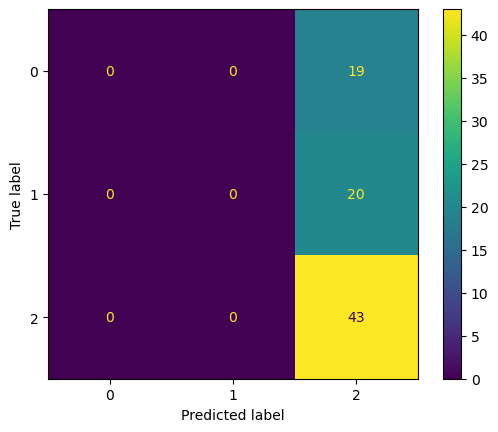

In [59]:
cm_display.plot()
plt.show() 

In [56]:
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

In [57]:
print(conf_matrix)

[[ 0  0 19]
 [ 0  0 20]
 [ 0  0 43]]
